In [1]:
!pip install pmdarima prophet xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.0 MB/s eta 0:00:00


In [2]:
# Download and extract dataset
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!unzip -qq household_power_consumption.zip

# Load only necessary columns
df = pd.read_csv("household_power_consumption.txt", sep=";",
                 parse_dates={'Datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False,
                 usecols=['Date','Time','Global_active_power'])

# Drop missing values
df = df.dropna()

# Convert to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'])

# Filter 2007–2008 data
df = df[(df['Datetime'] >= "2007-01-01") & (df['Datetime'] < "2009-01-01")]

# Resample to daily mean
df = df.set_index('Datetime').resample('D').mean()

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (731, 1)


,Global_active_power
Datetime,
2007-01-01,1.909031
2007-01-02,0.881414
2007-01-03,0.704204
2007-01-04,2.263481
2007-01-05,1.884281


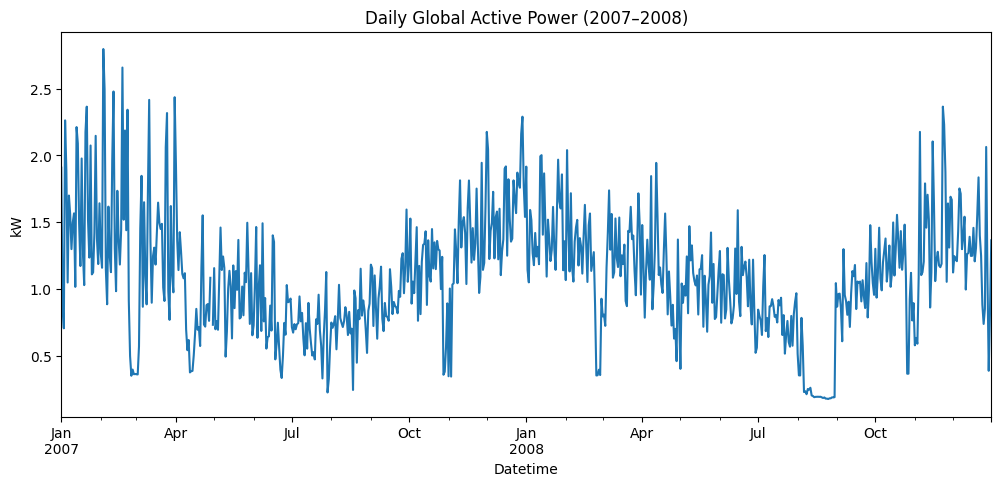

In [3]:
df['Global_active_power'].plot(figsize=(12,5), title="Daily Global Active Power (2007–2008)")
plt.ylabel("kW")
plt.show()


In [4]:
# Use last 90 days as test
train = df[:-90]
test = df[-90:]

print("Train size:", train.shape, "Test size:", test.shape)


Train size: (641, 1) Test size: (90, 1)


In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on training data
arima_model = ARIMA(train['Global_active_power'], order=(5,1,0))
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))


In [10]:
!pip install prophet==1.1.5 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 61.5 MB/s eta 0:00:00


In [11]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = train.reset_index().rename(columns={'Datetime':'ds','Global_active_power':'y'})

# Train Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Forecast future
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

# Collect predictions
prophet_forecast = forecast['yhat'][-len(test):].values


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc36jqlxp/8tb2i0xg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc36jqlxp/7qeak8wa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96818', 'data', 'file=/tmp/tmpc36jqlxp/8tb2i0xg.json', 'init=/tmp/tmpc36jqlxp/7qeak8wa.json', 'output', 'file=/tmp/tmpb31yk_ug/prophet_modele09txwfp/prophet_model-20250826115221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:52:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:52:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [12]:
from xgboost import XGBRegressor

# Create lag features for supervised learning
lagged = df.copy()
for lag in range(1,8):  # 7-day lag
    lagged[f'lag_{lag}'] = lagged['Global_active_power'].shift(lag)

lagged = lagged.dropna()

train_lag = lagged[:-90]
test_lag = lagged[-90:]

X_train = train_lag.drop('Global_active_power', axis=1)
y_train = train_lag['Global_active_power']
X_test = test_lag.drop('Global_active_power', axis=1)
y_test = test_lag['Global_active_power']

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_forecast = xgb_model.predict(X_test)


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def evaluate(true, pred, model_name):
    mae = mean_absolute_error(true, pred)
    rmse = sqrt(mean_squared_error(true, pred))
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Evaluate ARIMA (statsmodels)
evaluate(test, arima_forecast, "ARIMA")

# Evaluate Prophet
evaluate(test, prophet_forecast, "Prophet")

# Evaluate XGBoost
evaluate(y_test, xgb_forecast, "XGBoost")


ARIMA - MAE: 0.3171, RMSE: 0.4267
Prophet - MAE: 0.7782, RMSE: 0.8540
XGBoost - MAE: 0.3117, RMSE: 0.4180


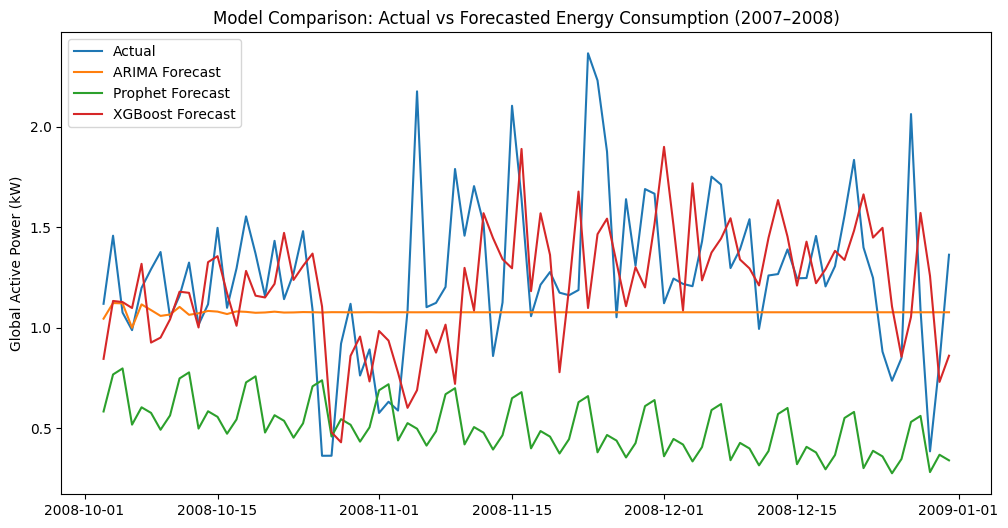

In [14]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.plot(test.index, prophet_forecast, label="Prophet Forecast")
plt.plot(test_lag.index, xgb_forecast, label="XGBoost Forecast")
plt.legend()
plt.title("Model Comparison: Actual vs Forecasted Energy Consumption (2007–2008)")
plt.ylabel("Global Active Power (kW)")
plt.show()
